<a href="https://colab.research.google.com/github/tjohanne42/time_series_project_simplon/blob/main/dev_files/time_series_collab_notebook_arthur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --upgrade statsmodels

     |████████████████████████████████| 9.5 MB 7.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
from datetime import datetime
from pathlib import Path
import sys
import os
import shutil
import joblib
tqdm.pandas()

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Conv1D, GlobalMaxPooling1D, SimpleRNN
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 20)

# from google.colab import drive
# drive.mount('drive/')

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
path_github_repo = Path.cwd() / "time_series_project_simplon"
if path_github_repo.is_dir():
    shutil.rmtree(path_github_repo)

!git clone https://github.com/tjohanne42/time_series_project_simplon.git
# %cd time_series_project_simplon/

from time_series_project_simplon.utils.functions import generate_df_by_time_section

Cloning into 'time_series_project_simplon'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 126 (delta 47), reused 74 (delta 23), pack-reused 0
Receiving objects: 100% (126/126), 11.63 MiB | 18.72 MiB/s, done.
Resolving deltas: 100% (47/47), done.


# import dataset

weekly nuclear production of energy

In [ ]:
!dir

drive  sample_data  time_series_project_simplon


In [ ]:
df_week = generate_df_by_time_section(time_section="week", verbose=True)
df_week

set the timestamp seconds, minutes and hours to 0 ...


  0%|          | 0/796411 [00:00<?, ?it/s]

get the mean of every hours for every days ...
add a column week
add a column year ...


  0%|          | 0/2772 [00:00<?, ?it/s]

get the mean of every day for every week ...
retrive the timestamp of the first day of each week ...
multiply all values by 12 * 24 * 7 to get the actual values by week ...
done


,timestamp,year,week,coal,nuclear,wind,hydro,solar
0,2012-01-01,2011,52,1.713828e+07,1.420676e+07,5.322716e+06,1.585388e+06,0.000000e+00
1,2012-01-02,2012,1,2.914531e+07,1.501550e+07,4.839885e+06,1.635379e+06,0.000000e+00
2,2012-01-09,2012,2,3.676549e+07,1.460764e+07,2.751943e+06,1.566100e+06,0.000000e+00
3,2012-01-16,2012,3,3.644392e+07,1.524003e+07,4.198388e+06,1.267458e+06,0.000000e+00
4,2012-01-23,2012,4,3.853616e+07,1.670473e+07,2.227393e+06,1.345945e+06,0.000000e+00
...,...,...,...,...,...,...,...,...
393,2019-07-01,2019,27,0.000000e+00,9.631355e+06,7.683682e+06,3.867220e+05,4.858098e+06
394,2019-07-08,2019,28,1.557690e+05,9.956678e+06,3.944752e+06,5.637490e+05,3.799916e+06
395,2019-07-15,2019,29,9.756300e+04,1.119766e+07,6.731582e+06,5.027580e+05,3.807794e+06
396,2019-07-22,2019,30,4.317600e+04,1.071334e+07,9.077357e+06,7.786470e+05,3.918022e+06


In [ ]:
df_nuclear_week = df_week[["timestamp", "nuclear"]]
df_nuclear_week

,timestamp,nuclear
0,2012-01-01,1.420676e+07
1,2012-01-02,1.501550e+07
2,2012-01-09,1.460764e+07
3,2012-01-16,1.524003e+07
4,2012-01-23,1.670473e+07
...,...,...
393,2019-07-01,9.631355e+06
394,2019-07-08,9.956678e+06
395,2019-07-15,1.119766e+07
396,2019-07-22,1.071334e+07


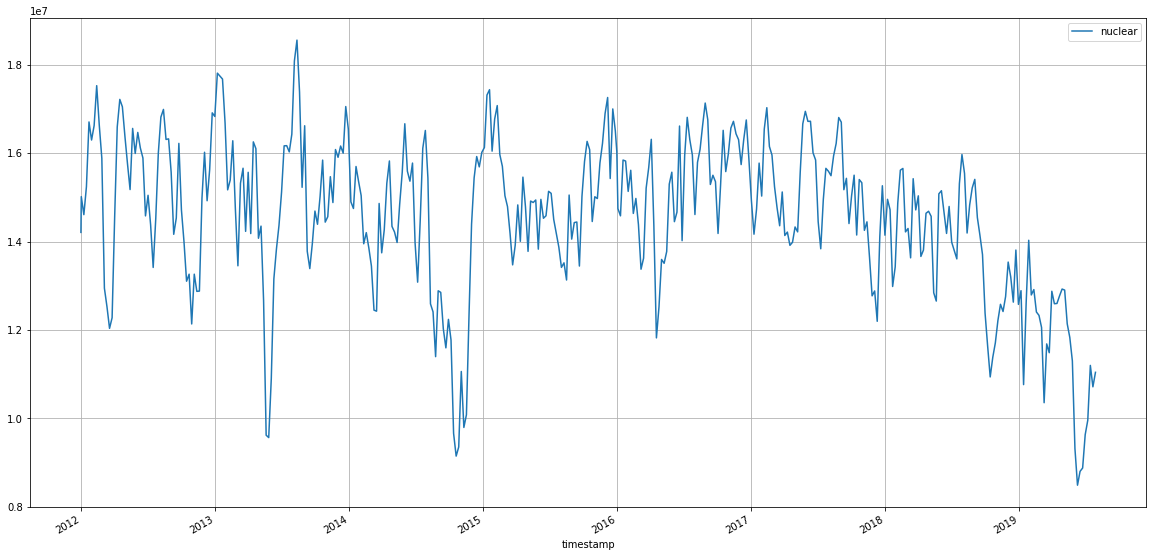

In [ ]:
# df_nuclear_week.plot(figsize=(20,10))
df_nuclear_week.set_index(keys="timestamp").plot(figsize=(20,10), grid=True)

# LSTM (with Time Series Generator)

- LSTM activation -> Sigmoid, tanh
- activation = "tanh", recurrent
- learning rate = 0.001, adam optimizer
- adaptive learning rates ? (Learning Rate Schedules, ReduceLROnPlateau)
- train, val, test set
- LSTM, dense, dropout layers
- Relu, leaky Relu, P Relu activation functions
- N input timestamps, M output timestamps

## train, validation, test sets

train (split_1) validation (split_2) test

In [ ]:
index_split_1 = round(len(df_nuclear_week) * 0.7)
index_split_2 = round(len(df_nuclear_week) * 0.8)

train = df_nuclear_week.iloc[:index_split_1, 1].values.reshape(-1, 1)
val = df_nuclear_week.iloc[index_split_1:index_split_2, 1].values.reshape(-1, 1)
test = df_nuclear_week.iloc[index_split_2:, 1].values.reshape(-1, 1)

In [ ]:
print(train.shape)
print(val.shape)
print(test.shape)

## MinMax scaling

In [ ]:
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

print(scaled_train.min(), scaled_train.max())

In [ ]:
print(train.shape, scaled_train.shape)

In [ ]:
# train
# scaler.inverse_transform(scaled_test)
# np.hstack([train, scaler.inverse_transform(scaled_train)])

In [ ]:
np.array_equal(train, scaler.inverse_transform(scaled_train))
# false but close enough

## Time series Generator

generates 2 objects x and y:<br>
x is the list the "input_length" last values of the time series,<br>
y is the next value.

In [ ]:
input_length = 24
features_length = 1
batch_size = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=input_length, batch_size=batch_size)

# we need to add the last "input_length" values of scaled train to scaled_val,
# to create a generator of the right length
# print(scaled_train[-input_length:].shape, scaled_val.shape)
scaled_val_for_generator = np.vstack([scaled_train[-input_length:], scaled_val])
# scaled_val_for_generator.shape
val_generator = TimeseriesGenerator(scaled_val_for_generator, scaled_val_for_generator, length=input_length, batch_size=batch_size)

In [ ]:
x, y = train_generator[3]
# print(x)
# print(y)

In [ ]:
len(train_generator), len(val_generator)

In [ ]:
print(x.shape)
print(y.shape)

x (input) shape = (batch size, input length, features length)<br>
y (expected output) shape = (batch size, output length)

## create a model

In [ ]:
LSTM?

In [ ]:
# inputs = Input(shape=(input_length, features_length))

# # main = Dense(n_lag, activation="relu")(inputs)
# main = LSTM(256, activation="tanh", return_sequences=True)(inputs)
# main = LSTM(128, activation="tanh", return_sequences=True)(main)
# main = LSTM(64, activation="tanh")(main)
# # main = Dense(64, activation="relu")(main)
# main = Dense(1, activation="relu", name='output')(main)

# model = Model(inputs, main)

# model.summary()
# plot_model(model, to_file="model.png", show_shapes=True)

# model.compile(
#   optimizer = Adam(learning_rate=0.001),
# #   optimizer = RMSprop(learning_rate=0.001),
#   loss = "mse",
# )

model = Sequential()

model.add(Input(shape=(input_length, features_length), name="input"))

model.add(LSTM(256, activation="tanh", return_sequences=True, name="LSTM_256"))
model.add(LSTM(128, activation="tanh", return_sequences=True, name="LSTM_128"))
model.add(LSTM(64, activation="tanh", name="LSTM_64"))

model.add(Dense(1, activation="relu", name='output'))

model.compile(
  optimizer = Adam(learning_rate=0.0001),
#   optimizer = RMSprop(learning_rate=0.001),
  loss = "mse"
)

model.summary()
plot_model(model, to_file="model.png", show_shapes=True, rankdir="TB")

## train the model

- checkpoints during training
- add logs
- save checkpoints and logs on google drive

In [ ]:
# remove previous checkpoints
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
root, _, ckpts = next(os.walk(path_models / "weights_checkpoints"))
for ckpt in ckpts:
    os.remove(Path(root) / ckpt)

In [ ]:
# model_checkpoints
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
model_name = "my_model"

history = model.fit(
    train_generator,
    batch_size=batch_size,
    validation_data=val_generator,
    epochs=10,
    verbose=2,
    callbacks=[
        TqdmCallback(verbose=2),
        EarlyStopping(monitor='loss', patience=3),
        ModelCheckpoint(filepath=path_models / "weights_checkpoints" / "weights_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.hdf5",
                        verbose=0, save_best_only=False,
                        save_weights_only=True, mode='auto', save_freq='epoch',
                        options=None)
    ],
    # workers=-1,
    # use_multiprocessing=True
)

# save model
model.save(path_models / model_name)

# save fit history
joblib.dump(history.history, path_models / model_name / "fit_history.pkl")

# save model png representation
path_model_png_file = Path.cwd().resolve() / "drive" / "MyDrive" / "time_series_models" / model_name / "model.png"
plot_model(model, to_file=str(path_model_png_file), show_shapes=True, rankdir="TB")

# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(history.history["loss"])), history.history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(history.history["val_loss"])), history.history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

In [ ]:
# model.fit?

## test the model


In [ ]:
# load model
model_dir_path = Path.cwd() / "saved_models"
loaded_model = keras.models.load_model(model_dir_path / "my_model")

# load fit history
fit_history = joblib.load(model_dir_path / "my_model" / "fit_history.pkl")

In [ ]:
# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(fit_history["loss"])), fit_history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(fit_history["val_loss"])), fit_history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

In [ ]:
# scaled_train

In [ ]:
# test_predictions must be of shape (len(df_test), 1) to
# be passed to scaler.inverse_transform
test_predictions = np.array([]).reshape((0,1))
first_batch_for_prediction = scaled_train[-input_length:].copy()
current_batch = first_batch_for_prediction.reshape((1, input_length, features_length))
# print(current_batch)

df_test = df_nuclear_week.iloc[index_split_2:, :].copy().set_index(keys="timestamp")
df_test

# model.predict(current_batch).shape

for index in tqdm(range(len(df_test))):
    # print()
    # print(current_batch)
    current_prediction = model.predict(current_batch)
    # print(current_prediction[0,0])
    # test_predictions.append(current_prediction)
    test_predictions = np.vstack((test_predictions, current_prediction))
    current_batch[0, :-1, 0] = current_batch[0, 1:, 0]
    current_batch[0, -1, 0] = current_prediction[0,0]
    # print(current_batch)
    # break
# print(test_predictions)

test_predictions_unnormalized = scaler.inverse_transform(test_predictions)
test_predictions_unnormalized

df_test["prediction"] = test_predictions_unnormalized
# df_test

# print(test_predictions_unnormalized)
df_test.plot(figsize=(14,5))

# LSTM (with nlag outputs)

In [ ]:
df_nuclear_week

,timestamp,nuclear
0,2012-01-01,1.420676e+07
1,2012-01-02,1.501550e+07
2,2012-01-09,1.460764e+07
3,2012-01-16,1.524003e+07
4,2012-01-23,1.670473e+07
...,...,...
393,2019-07-01,9.631355e+06
394,2019-07-08,9.956678e+06
395,2019-07-15,1.119766e+07
396,2019-07-22,1.071334e+07


## train, test sets

In [ ]:
index_split = round(len(df_nuclear_week) * 0.80)

train = df_nuclear_week.iloc[:index_split, 1].values.reshape(-1,1)
test = df_nuclear_week.iloc[index_split:, 1].values.reshape(-1,1)

In [ ]:
print(len(train), len(test))

318 80


## MinMax scaling

In [ ]:
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
print(scaled_train.min(), scaled_train.max())

0.0 1.0


## (input_length -> output_length) generator

let's try 16 -> 4

In [ ]:
input_length = 16
features_length = 1
output_length = 4

# X_train.shape = (n_examples, input_length)
# y_train.shape = (n_examples, output_length)
X_train = np.array([]).reshape((0, input_length))
y_train = np.array([]).reshape((0, output_length))

for example_index in tqdm(range(len(scaled_train) - input_length - output_length), desc="example index"):
    # print(example_index + input_length + output_length)
    X_train = np.vstack([X_train, scaled_train.flatten()[example_index                : example_index + input_length                ]])
    y_train = np.vstack([y_train, scaled_train.flatten()[example_index + input_length : example_index + input_length + output_length]])

# change X_train shape from (number of examples, input_length) to (number of examples, input_length, features_length)
X_train = X_train.reshape((-1, input_length, 1))

example index:   0%|          | 0/298 [00:00<?, ?it/s]

In [ ]:
print(X_train.shape, y_train.shape)

(298, 16, 1) (298, 4)


## create a model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16, 16)            32        
_________________________________________________________________
LSTM_64_1 (LSTM)             (None, 16, 64)            20736     
_________________________________________________________________
LSTM_64_2 (LSTM)             (None, 16, 64)            33024     
_________________________________________________________________
LSTM_64_3 (LSTM)             (None, 16, 64)            33024     
_________________________________________________________________
LSTM_64_4 (LSTM)             (None, 16, 64)            33024     
_________________________________________________________________
LSTM_64_5 (LSTM)             (None, 64)                33024     
_________________________________________________________________
output (Dense)               (None, 4)                

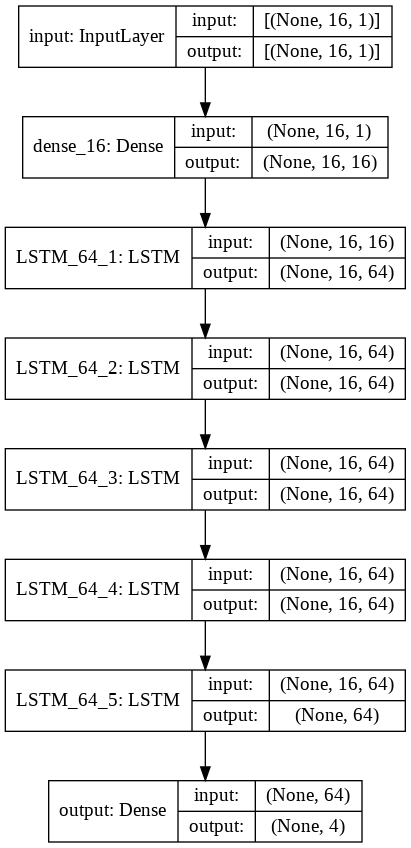

In [ ]:
model = Sequential()

model.add(Input(shape=(input_length, features_length), name="input"))

model.add(Dense(input_length, activation="relu", name=f"dense_{input_length}"))
model.add(LSTM(64, activation="tanh", return_sequences=True, name="LSTM_64_1"))
model.add(LSTM(64, activation="tanh", return_sequences=True, name="LSTM_64_2"))
model.add(LSTM(64, activation="tanh", return_sequences=True, name="LSTM_64_3"))
model.add(LSTM(64, activation="tanh", return_sequences=True, name="LSTM_64_4"))
model.add(LSTM(64, activation="tanh", name="LSTM_64_5"))
model.add(Dense(output_length, activation="relu", name='output'))

# model.add(LSTM(256, activation="tanh", return_sequences=True, name="LSTM_256"))
# model.add(LSTM(128, activation="tanh", return_sequences=True, name="LSTM_128"))
# model.add(LSTM(64, activation="tanh", name="LSTM_64"))
# model.add(Dense(1, activation="relu", name='output'))

# main = Dense(n_lag, activation="relu")(inputs)
# main = LSTM(256, activation="relu", return_sequences=True)(main)
# main = LSTM(128, activation="relu", return_sequences=True)(main)
# main = LSTM(64, activation="relu")(main)
# main = Dense(n_lag, activation=None, name='output')(main)

model.compile(
  optimizer = Adam(learning_rate=0.0001),
#   optimizer = RMSprop(learning_rate=0.001),
  loss = "mse"
)

model.summary()
plot_model(model, to_file="model.png", show_shapes=True, rankdir="TB")

## train the model

In [ ]:
# remove previous checkpoints
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
root, _, ckpts = next(os.walk(path_models / "weights_checkpoints"))
for ckpt in ckpts:
    os.remove(Path(root) / ckpt)

In [ ]:
# load a specific checkpoint
path_model_ckpts = Path.cwd() / "drive" / "MyDrive" / "time_series_models" / "weights_checkpoints"
ckpt_name = "weights_epoch_003_loss_0.1268_val_loss_0.1256.hdf5"
model.load_weights(filepath=str(path_model_ckpts / ckpt_name))

0epoch [00:00, ?epoch/s]

Epoch 1/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 13s - loss: 0.3764 - val_loss: 0.3703
Epoch 2/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3201 - val_loss: 0.3259
Epoch 3/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3087 - val_loss: 0.3260
Epoch 4/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3081 - val_loss: 0.3260
Epoch 5/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3081 - val_loss: 0.3261
Epoch 6/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3079 - val_loss: 0.3260
Epoch 7/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 2s - loss: 0.3078 - val_loss: 0.3259
Epoch 8/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 2s - loss: 0.3076 - val_loss: 0.3259
Epoch 9/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3076 - val_loss: 0.3260
Epoch 10/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3076 - val_loss: 0.3260
Epoch 11/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 2s - loss: 0.3074 - val_loss: 0.3260
Epoch 12/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3072 - val_loss: 0.3264
Epoch 13/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3074 - val_loss: 0.3260
Epoch 14/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3071 - val_loss: 0.3260
Epoch 15/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3070 - val_loss: 0.3266
Epoch 16/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 2s - loss: 0.3072 - val_loss: 0.3270
Epoch 17/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 2s - loss: 0.3071 - val_loss: 0.3262
Epoch 18/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 2s - loss: 0.3069 - val_loss: 0.3260
Epoch 19/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 1s - loss: 0.3070 - val_loss: 0.3259
Epoch 20/20


  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

30/30 - 2s - loss: 0.3070 - val_loss: 0.3271
saving model ...


INFO:tensorflow:Assets written to: /content/drive/MyDrive/time_series_models/model_3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/time_series_models/model_3/assets


done


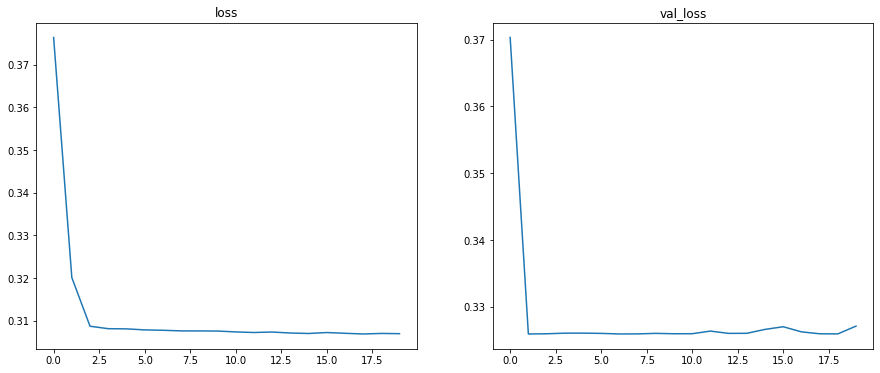

In [ ]:
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
model_name = "model_3"
path_model_dir = path_models / model_name
if path_model_dir.is_dir():
    shutil.rmtree(path_model_dir)
path_model_ckpts = path_models / "weights_checkpoints"

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    # initial_epoch=3,
    verbose=2,
    batch_size=8,
    callbacks=[
        TqdmCallback(verbose=2),
        # EarlyStopping(monitor='loss', patience=10),
        ModelCheckpoint(
            filepath = path_model_ckpts / "weights_epoch_{epoch:03d}_loss_{loss:.4f}_val_loss_{val_loss:.4f}.hdf5",
            # filepath = path_model_ckpts / "weights_epoch_{epoch:03d}_loss_{loss:.4f}.hdf5",
            verbose=0, save_best_only=False,
            save_weights_only=True, mode='auto', save_freq="epoch",
            options=None
        )
    ],
)

# save model
print("saving model ...")
model.save(path_model_dir)
print("done")

# save fit history
joblib.dump(history.history, path_model_dir / "fit_history.pkl")

# save model png representation
path_model_png_file = path_model_dir / "model.png"
plot_model(model, to_file=str(path_model_png_file), show_shapes=True, rankdir="TB")

# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(history.history["loss"])), history.history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(history.history["val_loss"])), history.history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

## test the model

In [ ]:
# load model
path_models = Path.cwd() / "drive" / "MyDrive" / "time_series_models"
model_name = "model_3"
loaded_model = keras.models.load_model(path_models / model_name)

# load fit history
fit_history = joblib.load(path_models / model_name / "fit_history.pkl")

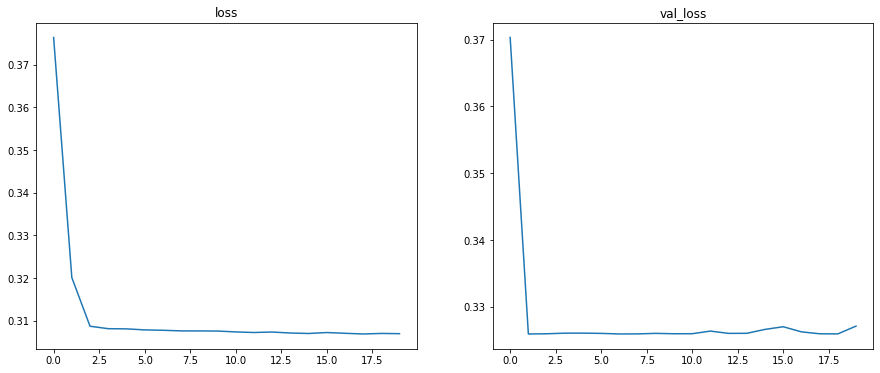

In [ ]:
# show loss and val_loss
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].plot(range(len(fit_history["loss"])), fit_history["loss"])
axes[0].set_title("loss")
axes[1].plot(range(len(fit_history["val_loss"])), fit_history["val_loss"])
axes[1].set_title("val_loss")
plt.show()

# DUMP

In [ ]:
try:
    raise ValueError
except Exception as error:
    print(type(error))